<a href="https://colab.research.google.com/github/Hani-kanaan/AAI614_hani_kanaan/blob/main/Detecting_Spam_Emails.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing necessary libraries for EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

# Importing libraries necessary for Model Building and Training
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
data = pd.read_csv('/content/emails.csv')
data.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [3]:
data.shape

(5728, 2)

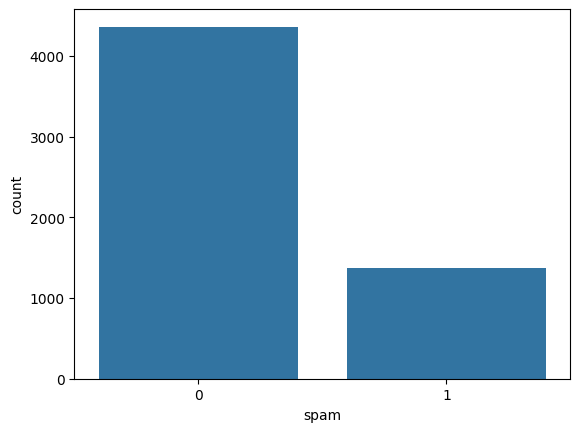

,count
spam,
0,4360
1,1368


In [4]:
sns.countplot(x='spam', data=data)
plt.show()
data['spam'].value_counts()

Text(0.5, 0, 'Message types')

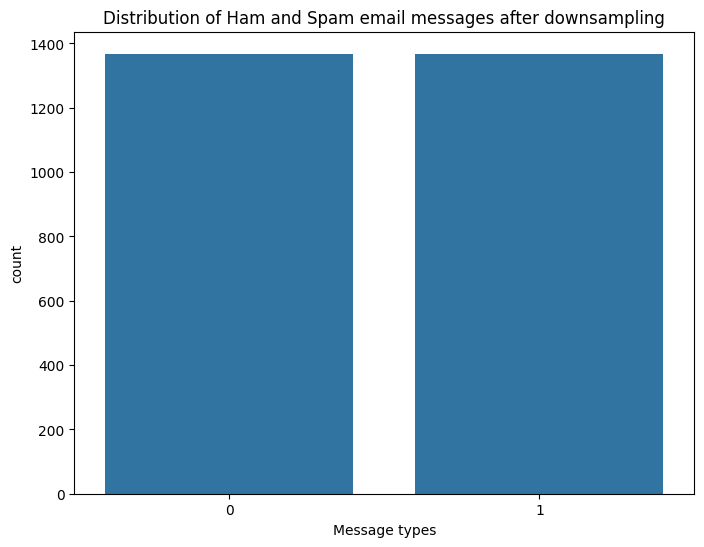

In [5]:

ham_msg = data[data.spam == 0]
spam_msg = data[data.spam == 1]
ham_msg = ham_msg.sample(n=len(spam_msg),
                         random_state=42)


balanced_data = pd.concat([ham_msg, spam_msg]).reset_index(drop=True)
plt.figure(figsize=(8, 6))
sns.countplot(data = balanced_data, x='spam')
plt.title('Distribution of Ham and Spam email messages after downsampling')
plt.xlabel('Message types')

In [6]:
balanced_data['text'] = balanced_data['text'].str.replace('Subject', '')
balanced_data.head()


,text,spam
0,: interview schedule for jinbaek kim i didn '...,0
1,": re : wednesday meeting eric , i think we c...",0
2,: re : london research group i ' d do it as s...,0
3,": re : congratulations vince , thanks for you...",0
4,: osman sezgen steve kromer is requesting tha...,0


In [7]:
punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

balanced_data['text']= balanced_data['text'].apply(lambda x: remove_punctuations(x))
balanced_data.head()


,text,spam
0,interview schedule for jinbaek kim i didn t...,0
1,re wednesday meeting eric i think we can ...,0
2,re london research group i d do it as soon...,0
3,re congratulations vince thanks for your n...,0
4,osman sezgen steve kromer is requesting that...,0


In [8]:

def remove_stopwords(text):
    stop_words = stopwords.words('english')

    imp_words = []

    # Storing the important words
    for word in str(text).split():
        word = word.lower()

        if word not in stop_words:
            imp_words.append(word)

    output = " ".join(imp_words)

    return output


balanced_data['text'] = balanced_data['text'].apply(lambda text: remove_stopwords(text))
balanced_data.head()


,text,spam
0,interview schedule jinbaek kim see went happy ...,0
1,wednesday meeting eric think skip meeting disc...,0
2,london research group soon possible call exact...,0
3,congratulations vince thanks note congratulati...,0
4,osman sezgen steve kromer requesting osman spe...,0


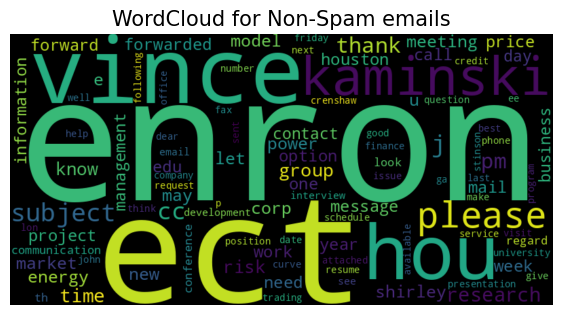

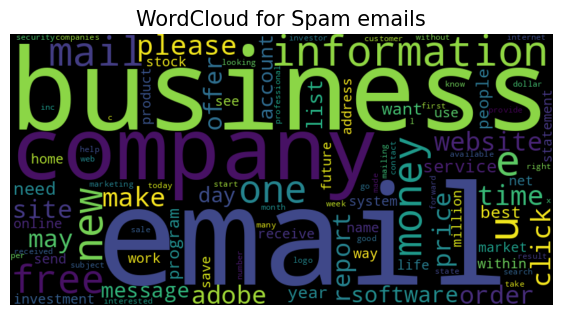

In [9]:
def plot_word_cloud(data, typ):
	email_corpus = " ".join(data['text'])

	plt.figure(figsize=(7, 7))

	wc = WordCloud(background_color='black',
				max_words=100,
				width=800,
				height=400,
				collocations=False).generate(email_corpus)

	plt.imshow(wc, interpolation='bilinear')
	plt.title(f'WordCloud for {typ} emails', fontsize=15)
	plt.axis('off')
	plt.show()

plot_word_cloud(balanced_data[balanced_data['spam'] == 0], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['spam'] == 1], typ='Spam')


In [10]:
#training the model:

In [11]:
#train test split
train_X, test_X, train_Y, test_Y = train_test_split(balanced_data['text'],
													balanced_data['spam'],
													test_size = 0.2,
													random_state = 42)


In [12]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

# Pad sequences to have the same length
max_len = 100 # maximum sequence length
train_sequences = pad_sequences(train_sequences,
								maxlen=max_len,
								padding='post',
								truncating='post')
test_sequences = pad_sequences(test_sequences,
							maxlen=max_len,
							padding='post',
							truncating='post')


In [13]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(
    input_dim=len(tokenizer.word_index) + 1,
    output_dim=32,
    input_length=max_len
))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Specify the input shape explicitly
model.build(input_shape=(None, max_len))

# Print the model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 32)             │         805,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 808,737 (3.09 MB)

 Trainable params: 808,737 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
			metrics = ['accuracy'],
			optimizer = 'adam')


In [15]:
es = EarlyStopping(patience=3,
				monitor = 'val_accuracy',
				restore_best_weights = True)

lr = ReduceLROnPlateau(patience = 2,
					monitor = 'val_loss',
					factor = 0.5,
					verbose = 0)


In [16]:
# Train the model
history = model.fit(train_sequences, train_Y,
					validation_data=(test_sequences, test_Y),
					epochs=20,
					batch_size=32,
					callbacks = [lr, es]
				)


Epoch 1/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.6224 - loss: 0.6611 - val_accuracy: 0.9270 - val_loss: 0.2675 - learning_rate: 0.0010
Epoch 2/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.9281 - loss: 0.2351 - val_accuracy: 0.9489 - val_loss: 0.2111 - learning_rate: 0.0010
Epoch 3/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9573 - loss: 0.1964 - val_accuracy: 0.9434 - val_loss: 0.2212 - learning_rate: 0.0010
Epoch 4/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9658 - loss: 0.1554 - val_accuracy: 0.9672 - val_loss: 0.1401 - learning_rate: 0.0010
Epoch 5/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9906 - loss: 0.0591 - val_accuracy: 0.9708 - val_loss: 0.1323 - learning_rate: 0.0010
Epoch 6/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9923 - loss: 0.0494 - val_accuracy: 0.9708 - val_loss: 0.1360 - learning_rate: 0.0010
Epoch 7/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9957 - loss: 0.0310 - val_acc

In [17]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9764 - loss: 0.1150
Test Loss : 0.13202452659606934
Test Accuracy : 0.9726277589797974


In [19]:
#user input for classification:

import re

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Tokenize and pad text using the tokenizer fitted on training data
    tokenized_text = tokenizer.texts_to_sequences([text])
    padded_text = pad_sequences(tokenized_text, maxlen=max_len, padding='post', truncating='post')  # Use max_len from training
    return padded_text # Return the padded sequence

# Prompt
while True:
    email_text = input("Enter email text to classify (or type 'exit' to quit): ")
    if email_text.lower() == 'exit':
        print("Exiting...")
        break

    # Preprocess the text
    processed_text = preprocess_text(email_text)

    # Predict spam or not spam
    prediction = model.predict(processed_text)
    result = 'Spam' if prediction > 0.5 else 'Not Spam'

    # Display the result
    print(f"Prediction: {result}\n")


Enter email text to classify (or type 'exit' to quit): make money fast
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
Prediction: Spam

Enter email text to classify (or type 'exit' to quit): meeting at 5 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction: Not Spam

Enter email text to classify (or type 'exit' to quit): exit
Exiting...
